In [51]:
import numpy as np
import torch
from torch.autograd import Variable
from src.modules.layers import SpectralPool
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg

import warnings
warnings.filterwarnings('ignore')

% matplotlib inline

In [50]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Spectral Pooling vs. Max Pooling

This is an example of spectral pooling on one image containing one channel. 

Spectral pooling has the advantage of reduced information loss compared to max pooling. 

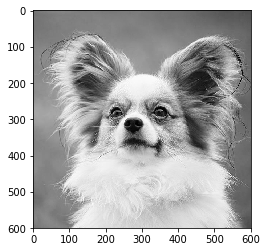

In [151]:
# Example original image using one channel 
# Since we use one image, batch = 1 
image = mpimg.imread('images/dog.jpg')
image = image[:,:,0]
plt.imshow(image, cmap='gray')

image = image[np.newaxis, np.newaxis, :, :]

In [83]:
def spectralpool(image, filter_height, filter_width): 
    spectral_pool = SpectralPool(filter_height, filter_width)
    img_var = spectral_pool.forward(image)
    return np.squeeze(img_var.data.numpy())

An extreme example of spectral pooling with large reductions to show how information is decreased as the image is further pooled.

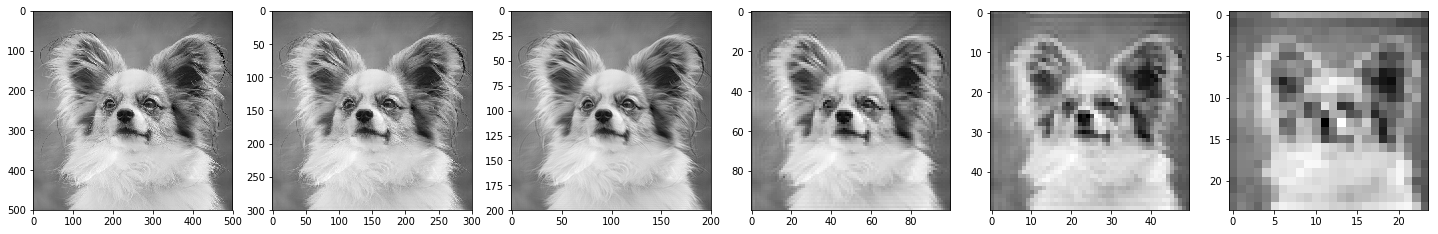

In [98]:
filter_size = [500, 300, 200, 100, 50, 25]

fig, axes = plt.subplots(1,6, figsize=(25,5))
for i in range(6): 
    ax = axes[i]
    ax.imshow(pool_and_display(image, filter_size[i], filter_size[i]), cmap='gray')

In the original paper, the authors used a filter size of 85% of the input image size. Using this reduction, the amount of information loss appears to be so little the image remains relatively unchanged. 

In [104]:
filter_size = [int(image.shape[2] * (.85 ** (i+1))) for i in range(6)]
filter_size

[510, 433, 368, 313, 266, 226]

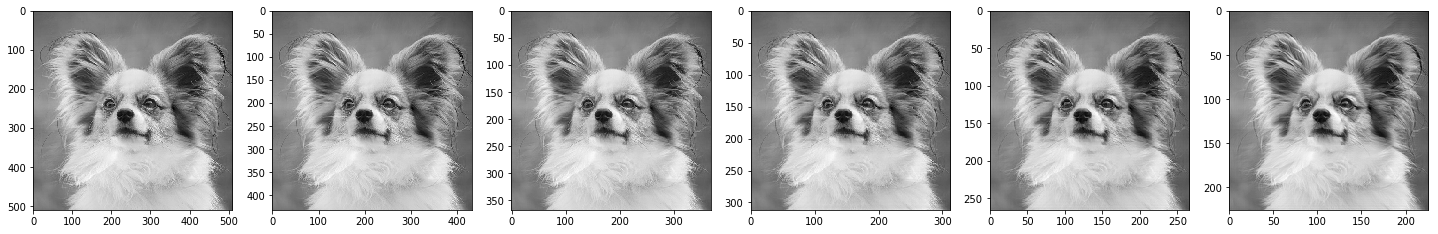

In [105]:
fig, axes = plt.subplots(1,6, figsize=(25,5))
for i in range(6): 
    ax = axes[i]
    ax.imshow(pool_and_display(image, filter_size[i], filter_size[i]), cmap='gray')

In comparison, max pooling quickly reduces the amount of information in the pooled images. The sample image is 600 x 600 so using a 4x4 max pooling kernel quickly blurs the details of the dog image. 

In [152]:
def maxpool(image): 
    m = torch.nn.MaxPool2d(4, stride=1)
    img_tensor = Variable(torch.from_numpy(image).float())
    pooled = m(img_tensor)
    return np.squeeze(pooled.data.numpy())

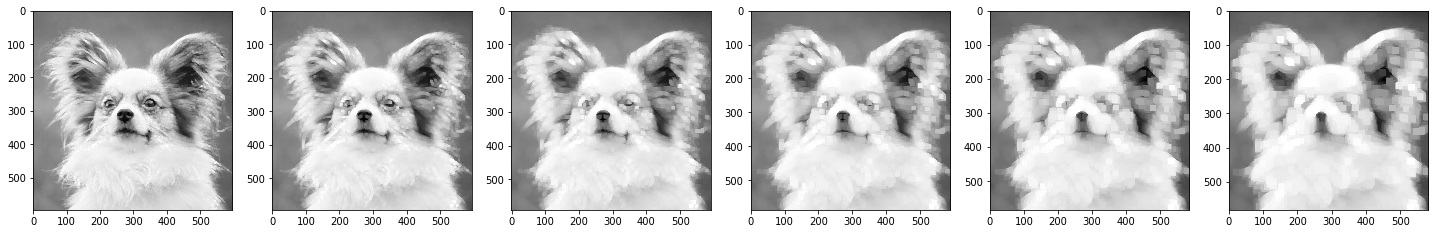

In [153]:
fig, axes = plt.subplots(1,6, figsize=(25,5))
for i in range(6): 
    ax = axes[i]
    image = maxpool(image)
    ax.imshow(image, cmap='gray')
    image = image[np.newaxis, np.newaxis, :, :]

# Spectral Pool forward and backward

Below shows that the spectral pooling forward and backward passes work

In [3]:
x = Variable(torch.randn(1,1,4,4), requires_grad=True)
print('x: ', x.data)

spectral_pool = SpectralPool(filter_height=2, filter_width=2)
result = spectral_pool(x)
print('Forward: ', result.data)

ground_truth = Variable(torch.randn(1,1,4,4), requires_grad=False)

loss = (ground_truth-x).pow(2).sum() 
print('Loss: ', loss.data)

loss.backward() 

print('Grad: ', x.grad.data)

x:  
(0 ,0 ,.,.) = 
 -1.1714 -0.0531 -1.3176 -0.3954
 -0.3377 -1.2796 -1.8483  0.3635
  1.1250  1.2558 -0.2110  1.1146
  0.1358  2.2572 -0.5064  1.7726
[torch.FloatTensor of size 1x1x4x4]

Forward:  
(0 ,0 ,.,.) = 
  1.8684  2.9034
  2.8889  2.1639
[torch.FloatTensor of size 1x1x2x2]

Loss:  
 33.0478
[torch.FloatTensor of size 1]

Grad:  
(0 ,0 ,.,.) = 
 -0.8665 -0.3242 -1.9755 -1.9506
 -5.5153 -3.5930 -4.9631 -1.9650
  3.0552 -0.7717 -0.5963  1.6347
  0.6682  2.6742 -3.1925  4.5889
[torch.FloatTensor of size 1x1x4x4]

